# Synthetic Discussions analysis

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import re

from tasks.graphs import save_plot
from tasks.stats import ndfu


def get_annotations(annot_str: str) -> dict:
    """Extracts all key-value pairs from the annotation string into a dictionary."""
    try:
        annot_str = str(annot_str).lower()
        # Regex to match key-value pairs of the form type=value
        pattern = r"(\w+)=([-\d\.]+)"
        matches = re.findall(pattern, annot_str)
        return {
            key: float(value) if "." in value else int(value) for key, value in matches
        }
    except Exception as e:
        return {}


def get_user_intent(prompt: str) -> str:
    prompt = prompt.lower()

    if "community" in prompt:
        return "Community-oriented"
    elif "troll" in prompt:
        return "Troll"
    elif "special_instructions: ," in prompt:
        return "Neutral"
    else:
        return "Unknown"


def format_dataset(df: pd.DataFrame, min_message_len: int) -> pd.DataFrame:
    df = df.astype(str)

    # Extract all annotations from the 'annotation' column
    annotations = df["annotation"].apply(get_annotations)

    # Convert each annotation dictionary into separate columns
    annotations_df = pd.json_normalize(annotations)

    # Concatenate the new columns with the original dataframe
    df = pd.concat([df, annotations_df], axis=1)
    df = df[(df.toxicity != -1) | (df.argumentquality != -1)]

    df.message_order = df.message_order.astype(int)

    # Process other columns as needed
    df.is_moderator = (df.is_moderator == "True").astype(bool)
    df["intent"] = df.user_prompt.apply(get_user_intent).astype(str)
    df.intent = np.where(df.is_moderator, "Moderator", df.intent).astype(str)

    df["polarization"] = (
        df.groupby(["conv_id", "message"])["toxicity"]
        .transform(lambda x: ndfu(x, histogram_input=False))
        .astype(float)
    )

    df["not_intervened"] = (
        df.is_moderator & df.message.apply(lambda x: len(x.strip()) < min_message_len)
    ).astype(bool)

    df = df.loc[
        :,
        [
            "conv_id",
            "message_id",
            "message_order",
            "conv_variant",
            "user",
            "user_prompt",
            "is_moderator",
            "intent",
            "message",
        ]
        + list(annotations_df.columns)
        + ["polarization", "not_intervened"],
    ]
    return df

In [2]:
MODERATION_STRATEGY_MAP = {
    "vanilla": "No Instructions",
    "moderation_game": "Moderation Game",
    "no_moderator": "No Moderator",
    "erulemaking": "Human Mod. Guidelines",
    "constructive_communications": "Human Fac. Guidelines",
    "collective_constitution": "Rules Only"
}

In [3]:
full_df = pd.read_csv("../data/dataset.csv", encoding="utf8")
full_df.conv_variant = full_df.conv_variant.map(MODERATION_STRATEGY_MAP)
full_df = format_dataset(full_df, min_message_len=3)
full_df = full_df.rename({"argumentquality": "Argument Quality"}, axis=1)
full_df


,conv_id,message_id,message_order,conv_variant,user,user_prompt,is_moderator,intent,message,toxicity,Argument Quality,polarization,not_intervened
0,1809810f-858f-468c-b9a4-bbcf0523bcdb,233759008509151825,1,No Instructions,OptimisticNurse42,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.375,False
1,1809810f-858f-468c-b9a4-bbcf0523bcdb,233759008509151825,1,No Instructions,OptimisticNurse42,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.375,False
2,1809810f-858f-468c-b9a4-bbcf0523bcdb,233759008509151825,1,No Instructions,OptimisticNurse42,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.375,False
3,1809810f-858f-468c-b9a4-bbcf0523bcdb,233759008509151825,1,No Instructions,OptimisticNurse42,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.375,False
4,1809810f-858f-468c-b9a4-bbcf0523bcdb,233759008509151825,1,No Instructions,OptimisticNurse42,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,3,0.375,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15153,ea09d5b8-22f5-4c75-a838-80c63ba84ff2,312115990056183053,29,Human Fac. Guidelines,moderator,You are a human participating in an online cha...,True,Moderator,"@SkepticalInvestor77, I understand your desire...",2,4,0.000,False
15154,ea09d5b8-22f5-4c75-a838-80c63ba84ff2,312115990056183053,29,Human Fac. Guidelines,moderator,You are a human participating in an online cha...,True,Moderator,"@SkepticalInvestor77, I understand your desire...",2,4,0.000,False
15155,ea09d5b8-22f5-4c75-a838-80c63ba84ff2,312115990056183053,29,Human Fac. Guidelines,moderator,You are a human participating in an online cha...,True,Moderator,"@SkepticalInvestor77, I understand your desire...",2,4,0.000,False
15156,ea09d5b8-22f5-4c75-a838-80c63ba84ff2,312115990056183053,29,Human Fac. Guidelines,moderator,You are a human participating in an online cha...,True,Moderator,"@SkepticalInvestor77, I understand your desire...",2,4,0.000,False


In [4]:
df = full_df[~full_df.not_intervened]
df

,conv_id,message_id,message_order,conv_variant,user,user_prompt,is_moderator,intent,message,toxicity,Argument Quality,polarization,not_intervened
0,1809810f-858f-468c-b9a4-bbcf0523bcdb,233759008509151825,1,No Instructions,OptimisticNurse42,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.375,False
1,1809810f-858f-468c-b9a4-bbcf0523bcdb,233759008509151825,1,No Instructions,OptimisticNurse42,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.375,False
2,1809810f-858f-468c-b9a4-bbcf0523bcdb,233759008509151825,1,No Instructions,OptimisticNurse42,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.375,False
3,1809810f-858f-468c-b9a4-bbcf0523bcdb,233759008509151825,1,No Instructions,OptimisticNurse42,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,2,0.375,False
4,1809810f-858f-468c-b9a4-bbcf0523bcdb,233759008509151825,1,No Instructions,OptimisticNurse42,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,3,0.375,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15153,ea09d5b8-22f5-4c75-a838-80c63ba84ff2,312115990056183053,29,Human Fac. Guidelines,moderator,You are a human participating in an online cha...,True,Moderator,"@SkepticalInvestor77, I understand your desire...",2,4,0.000,False
15154,ea09d5b8-22f5-4c75-a838-80c63ba84ff2,312115990056183053,29,Human Fac. Guidelines,moderator,You are a human participating in an online cha...,True,Moderator,"@SkepticalInvestor77, I understand your desire...",2,4,0.000,False
15155,ea09d5b8-22f5-4c75-a838-80c63ba84ff2,312115990056183053,29,Human Fac. Guidelines,moderator,You are a human participating in an online cha...,True,Moderator,"@SkepticalInvestor77, I understand your desire...",2,4,0.000,False
15156,ea09d5b8-22f5-4c75-a838-80c63ba84ff2,312115990056183053,29,Human Fac. Guidelines,moderator,You are a human participating in an online cha...,True,Moderator,"@SkepticalInvestor77, I understand your desire...",2,4,0.000,False


## Analysis

### User intent impact on toxicity

In [5]:
METRICS = ["toxicity", "Argument Quality", "polarization"]
GRAPH_OUTPUT_DIR = Path("../graphs")
TOXICITY_TICKS = np.arange(1, 6, 1)
POLARIZATION_TICKS = np.arange(0, 1.2, 0.2)

sns.set(style="whitegrid")


def plot_metrics_barplots(group_by_col: str, group_by_col_label: str) -> None:
    fig, axes = plt.subplots(1, len(METRICS))
    fig.set_size_inches(12, 6)

    for ax, metric in zip(axes, METRICS):

        sns.barplot(
            data=df,
            x=group_by_col,
            hue=group_by_col,
            y=metric,
            errorbar="sd",
            legend=False,
            ax=ax,
        )
        ax.tick_params(axis="x", labelrotation=90, labelsize=8)
        ax.set_xlabel("")
        ax.set_ylabel(metric.capitalize())
        if metric == "toxicity" or metric == "Argument Quality":
            ax.set_yticks(TOXICITY_TICKS)
        else:
            ax.set_yticks(POLARIZATION_TICKS)

    fig.suptitle(f"Impact of {group_by_col_label} on Discussions")
    fig.supxlabel(group_by_col_label)
    fig.supylabel("Annotation Scores")
    fig.tight_layout()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_barplot.png


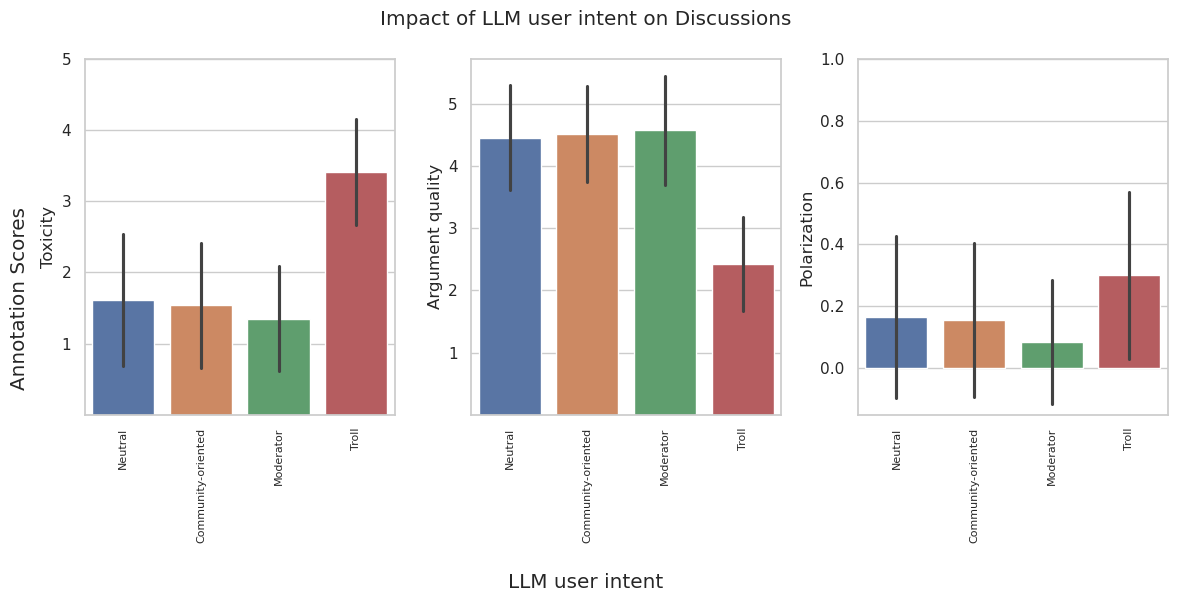

In [6]:
plot_metrics_barplots("intent", "LLM user intent")
save_plot(path=GRAPH_OUTPUT_DIR / "intent_barplot.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_barplot.png


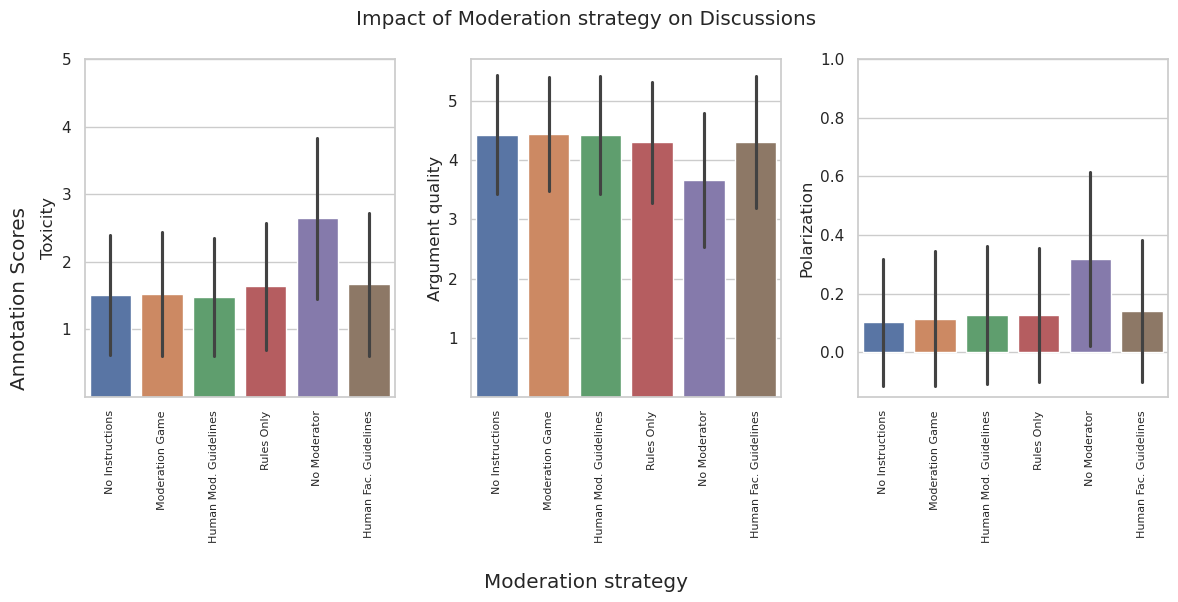

In [7]:
plot_metrics_barplots("conv_variant", "Moderation strategy")
save_plot(path=GRAPH_OUTPUT_DIR / "strategy_barplot.png")
plt.show()

### Progression of toxicity

In [8]:
def plot_timeseries_heatmap(timeseries_df: pd.DataFrame, metric_column: str) -> None:
    """
    Plots a heatmap showing the toxicity of all conversations over message order, sorted by discussion length.

    :param timeseries_df: DataFrame containing conversation data with toxicity and message_order
    :param metric: The metric to display in the heatmap title
    """
    # Group by 'conv_id' and 'message_order', then calculate the average of the metric column
    heatmap_data = df.groupby(['conv_id', 'message_order'])[metric_column].mean().unstack()

    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(heatmap_data, cmap='cividis', cbar_kws={'label': f'Average {metric_column.capitalize()}'}, annot=False, fmt='.2f')
    ax.grid(False)
    ax.set(yticklabels=[])

    plt.title(f'Average {metric_column.capitalize()} per Conversation ID and Message Order')
    plt.xlabel('Message Order')
    plt.ylabel('Conversation ID')

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/toxicity_heatmap.png


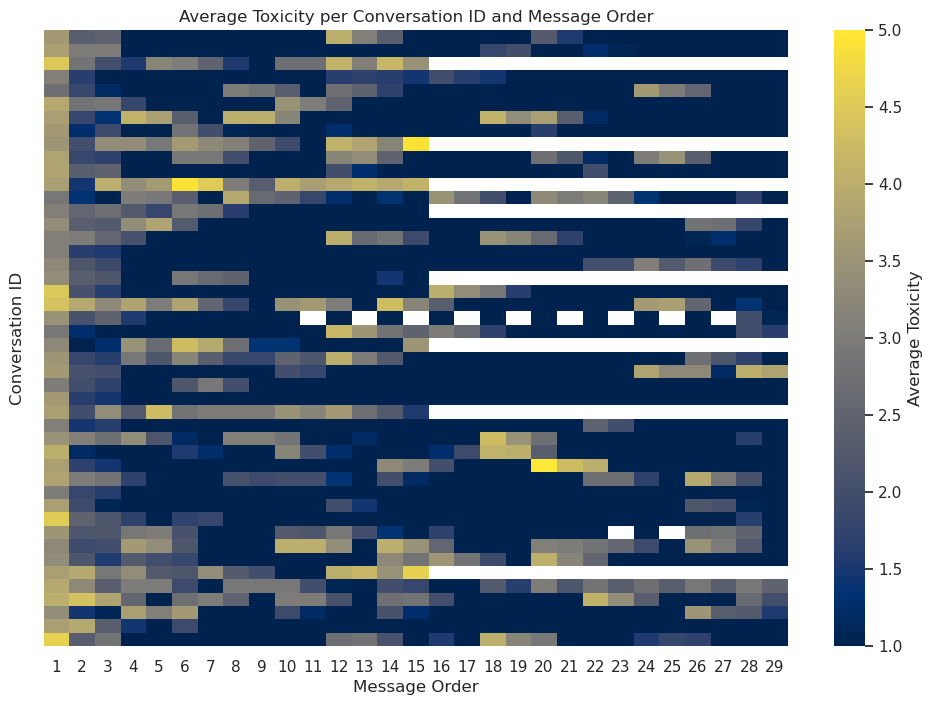

In [9]:
plot_timeseries_heatmap(df, "toxicity")
save_plot(path=GRAPH_OUTPUT_DIR / "toxicity_heatmap.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/polarization_heatmap.png


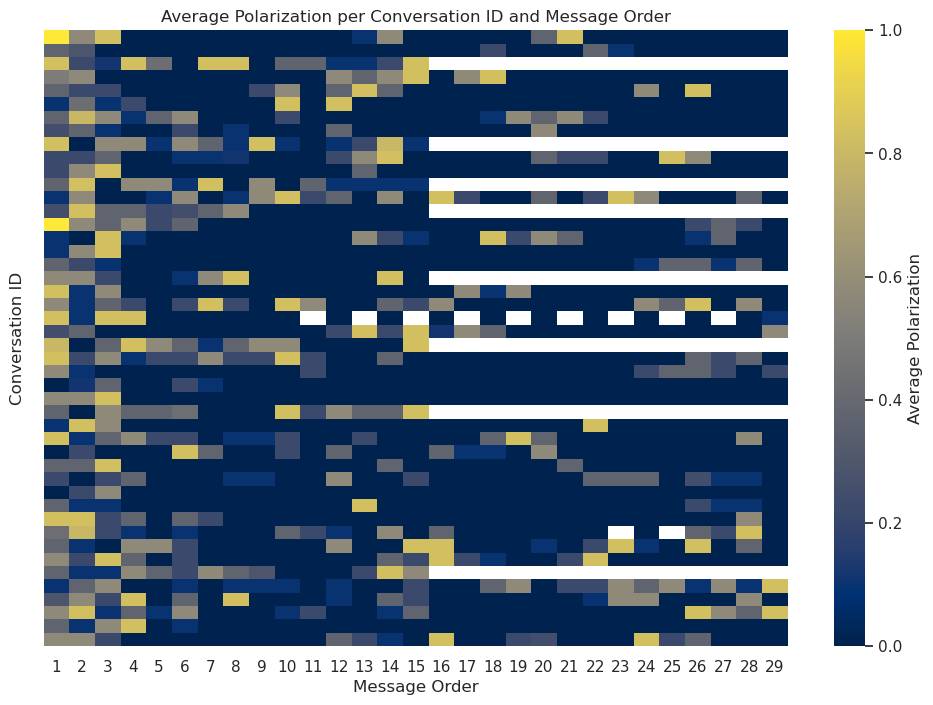

In [10]:
plot_timeseries_heatmap(df, "polarization")
save_plot(path=GRAPH_OUTPUT_DIR / "polarization_heatmap.png")
plt.show()

### Moderator impact

In [11]:
def plot_timeseries(df: pd.DataFrame, y_col: str, hue_col: str, hue_col_label: str) -> None:
    plt.figure(figsize=(12, 6))

    sns.lineplot(
        data=df,
        x="message_order",
        y=y_col,
        hue=hue_col,
        lw=1,
        alpha=0.6,
    )

    plt.title(f"Average (all comments from all annotators) {y_col.capitalize()} by {hue_col_label}")
    plt.xlabel("Discussion Length (# messages)")
    plt.ylabel(f"Average {y_col.capitalize()}")
    plt.xticks(rotation=45)

    plt.legend(title=hue_col_label)
    plt.tight_layout()

### Intent Impact

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_toxicity_timeseries.png


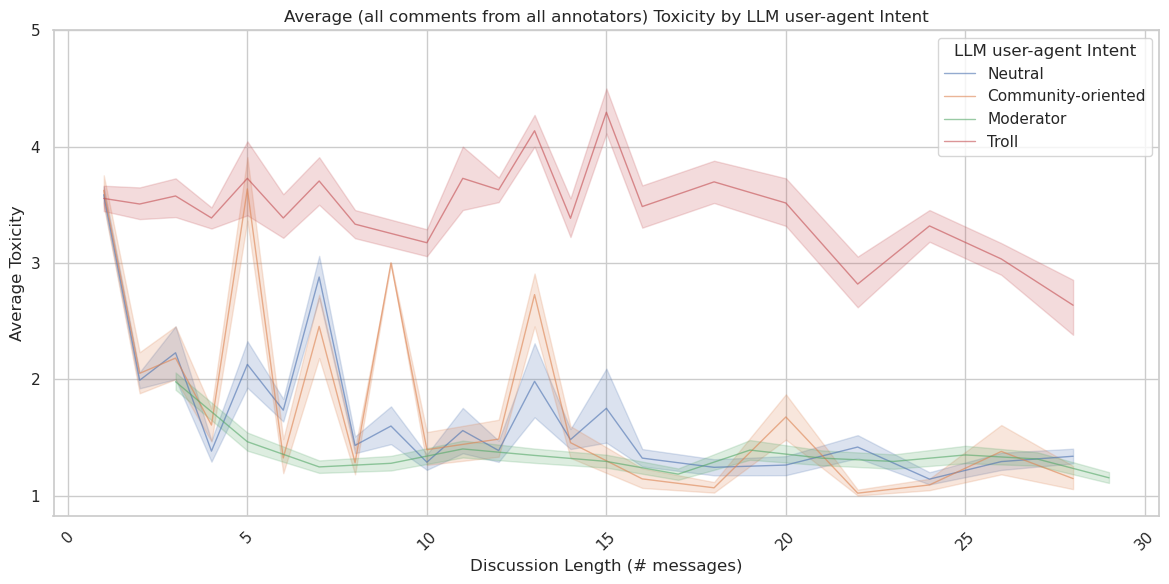

In [12]:
plot_timeseries(df, y_col="toxicity", hue_col="intent", hue_col_label="LLM user-agent Intent")
plt.yticks(TOXICITY_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "intent_toxicity_timeseries.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_polarization_timeseries.png


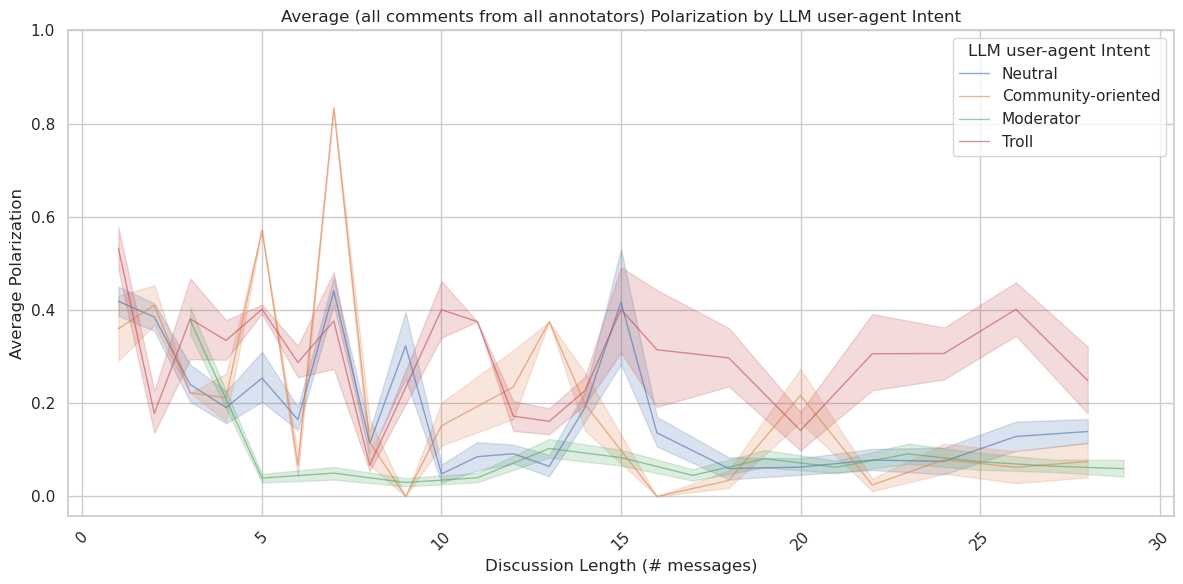

In [13]:
plot_timeseries(df, y_col="polarization", hue_col="intent", hue_col_label="LLM user-agent Intent")
plt.yticks(POLARIZATION_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "intent_polarization_timeseries.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intent_argument_timeseries.png


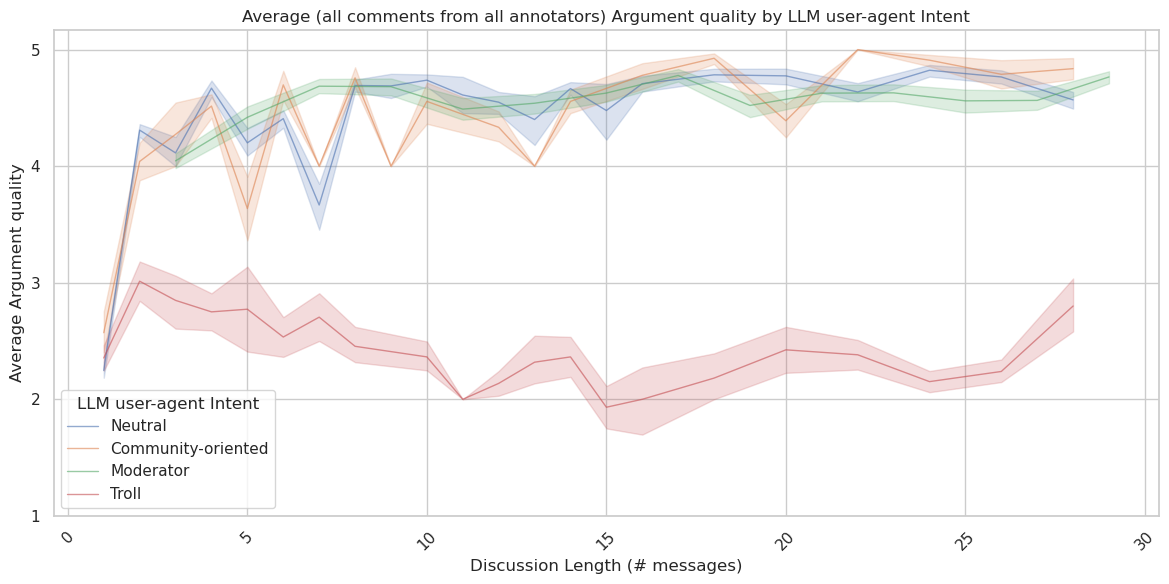

In [14]:
plot_timeseries(df, y_col="Argument Quality", hue_col="intent", hue_col_label="LLM user-agent Intent")
plt.yticks(TOXICITY_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "intent_argument_timeseries.png")
plt.show()

### Moderation Strategy Impact

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_toxicity_timeseries.png


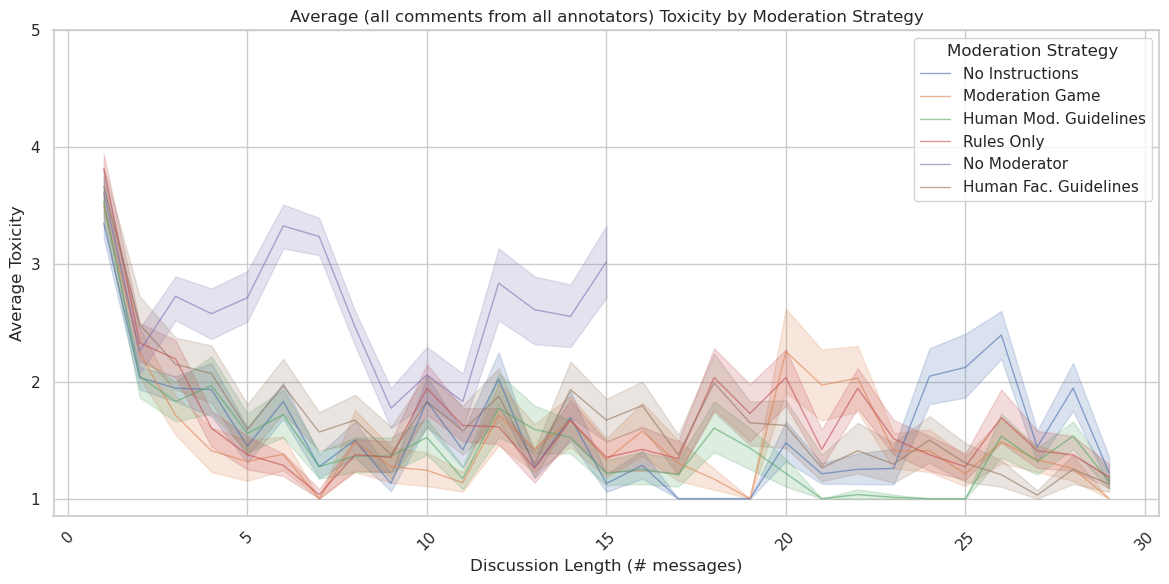

In [15]:
plot_timeseries(df, y_col="toxicity", hue_col="conv_variant", hue_col_label="Moderation Strategy")
plt.yticks(TOXICITY_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "strategy_toxicity_timeseries.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_polarization_timeseries.png


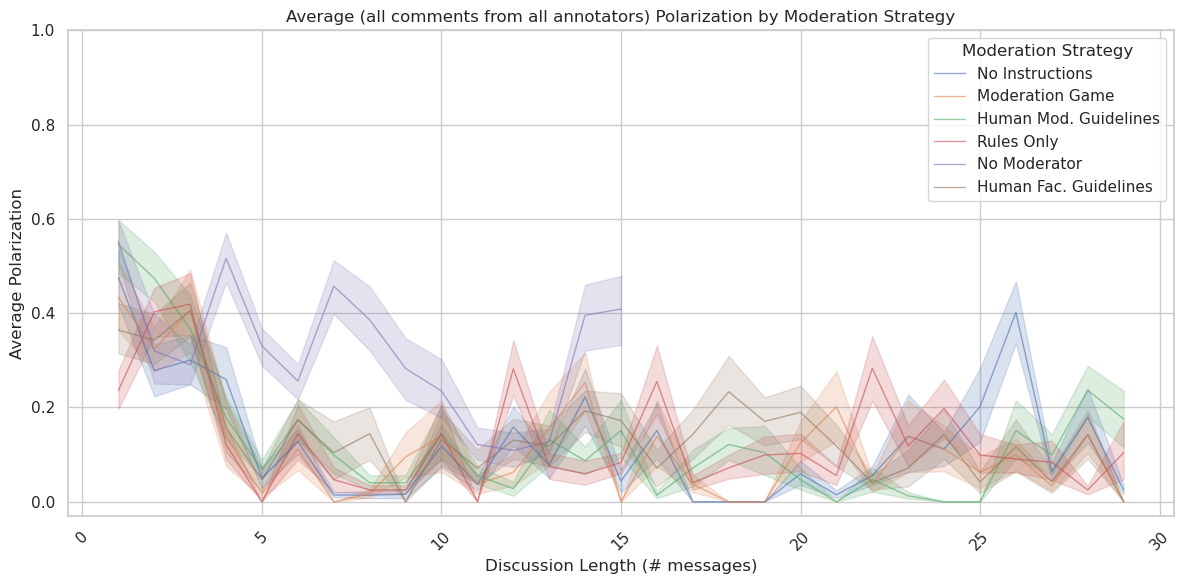

In [16]:
plot_timeseries(df, y_col="polarization", hue_col="conv_variant", hue_col_label="Moderation Strategy")
plt.yticks(POLARIZATION_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "strategy_polarization_timeseries.png")
plt.show()

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/strategy_argument_timeseries.png


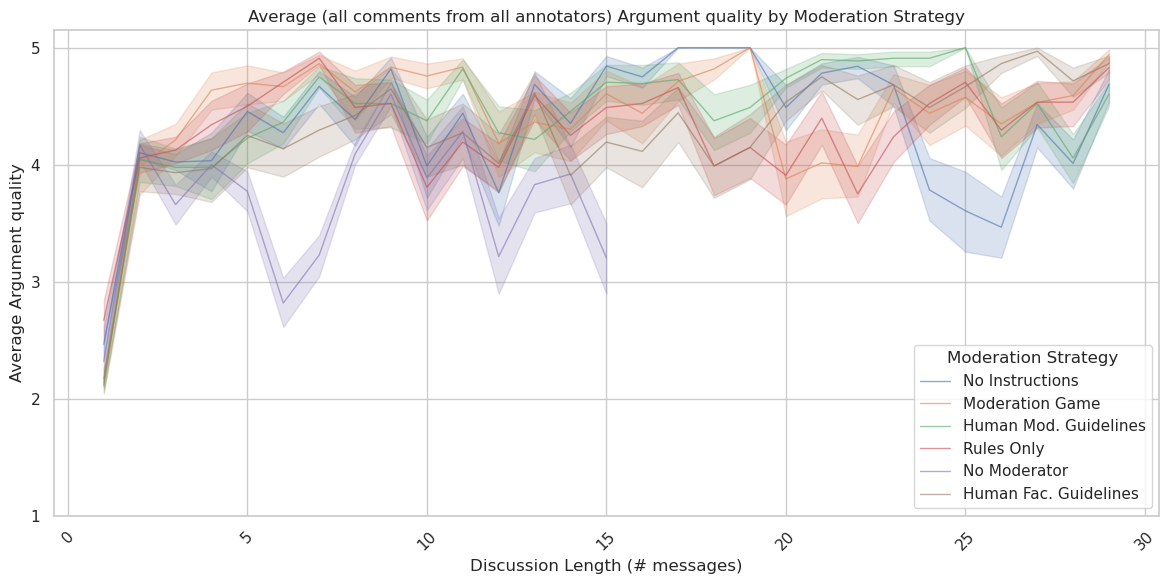

In [17]:
plot_timeseries(df, y_col="Argument Quality", hue_col="conv_variant", hue_col_label="Moderation Strategy")
plt.yticks(TOXICITY_TICKS)

save_plot(path=GRAPH_OUTPUT_DIR / "strategy_argument_timeseries.png")
plt.show()

### Moderator Interventions

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/intervention_count.png


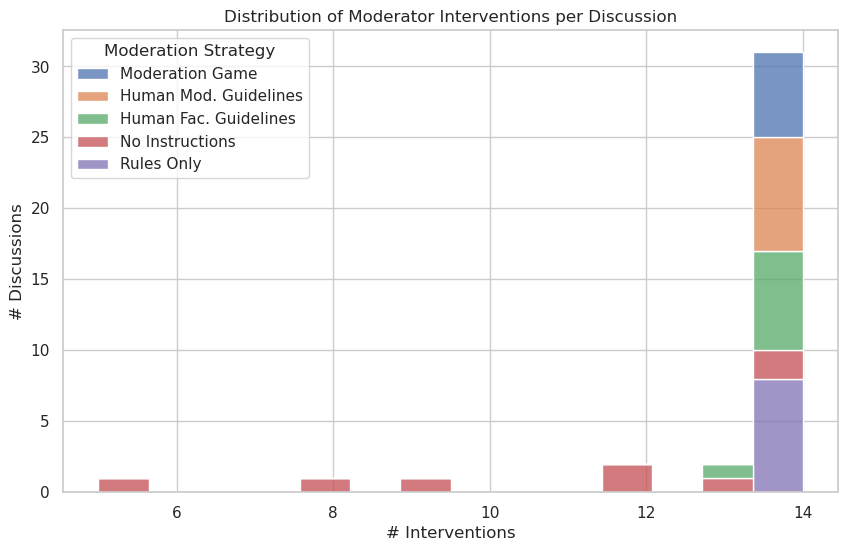

In [37]:
df_unique = df[df["conv_variant"] != "no_moderator"].drop_duplicates(
    subset=["message_id"]
)

# Compute number of moderator interventions per conversation
moderator_interventions = df_unique[df_unique["is_moderator"]].groupby("conv_id").size()

# Merge with conversation variants
conv_variants = (
    df_unique[["conv_id", "conv_variant"]].drop_duplicates().set_index("conv_id")
)
moderator_interventions = moderator_interventions.to_frame(
    name="moderator_interventions"
).join(conv_variants, how="left")

plt.figure(figsize=(10, 6))
sns.histplot(
    data=moderator_interventions.rename({"conv_variant": "Moderation Strategy"}, axis=1),
    x="moderator_interventions",
    hue="Moderation Strategy",
    multiple="stack",
    bins=14,
)
plt.xlabel("# Interventions")
plt.ylabel("# Discussions")
plt.title("Distribution of Moderator Interventions per Discussion")

save_plot(path=GRAPH_OUTPUT_DIR / "intervention_count.png")
plt.show()

### Annotators

Figure saved to /home/dimits/Documents/research/synthetic_moderation_experiments/graphs/polarization_toxicity.png


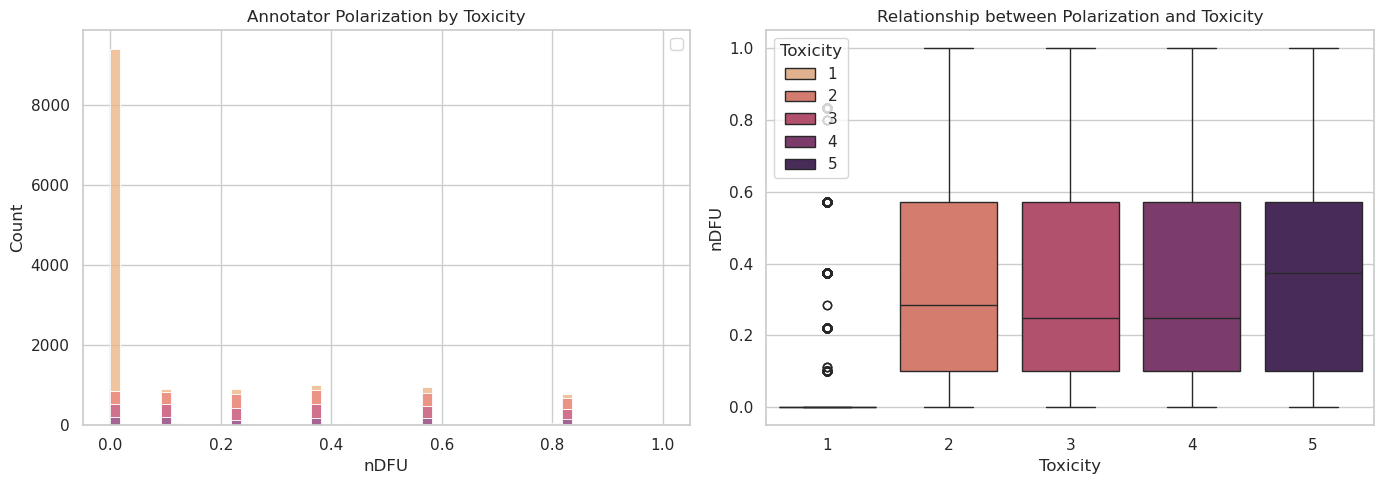

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df, x="polarization", hue="toxicity", palette="flare", multiple="stack", ax=axes[0])
axes[0].set_title("Annotator Polarization by Toxicity")
axes[0].set_xlabel("nDFU")
axes[0].legend("")

sns.boxplot(df, y="polarization", x="toxicity", hue="toxicity", palette="flare", ax=axes[1])
axes[1].set_title("Relationship between Polarization and Toxicity")
axes[1].set_xlabel("Toxicity")
axes[1].set_ylabel("nDFU")
axes[1].legend(title="Toxicity", loc="upper left")

plt.tight_layout()

save_plot(GRAPH_OUTPUT_DIR / "polarization_toxicity.png")
plt.show()


## Investigating the rise of vanilla annotations

In [20]:
def intent_ratio(sus_df, other_df):
    other_value_counts = other_df.intent.value_counts()
    other_ratio = other_value_counts["Troll"] / other_value_counts.sum() * 100

    sus_value_counts = sus_df.intent.value_counts()
    sus_ratio = sus_value_counts["Troll"] / sus_value_counts.sum() * 100

    print(f"Suspicious area troll/other ratio: {sus_ratio:.2f}%")
    print(f"Other area troll/other ratio: {other_ratio:.2f}%")


Explain vanilla bump:

In [21]:
vanilla_df = df[df.conv_variant=="No Instructions"]
sus_df = vanilla_df[(vanilla_df.message_order <= 28) & (vanilla_df.message_order >= 23)]
other_df = vanilla_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 14.29%
Other area troll/other ratio: 7.64%


Explain moderation game bump:

In [22]:
mod_game_df = df[df.conv_variant=="Moderation Game"]
sus_df = mod_game_df[(mod_game_df.message_order <= 22) & (mod_game_df.message_order >= 19)]
other_df = mod_game_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 12.50%
Other area troll/other ratio: 5.75%


Baseline: ratios on stable area

In [23]:
vanilla_df = df[df.conv_variant=="No Instructions"]
sus_df = vanilla_df[(vanilla_df.message_order <= 22) & (vanilla_df.message_order >= 19)]
other_df = vanilla_df

intent_ratio(sus_df, other_df)

Suspicious area troll/other ratio: 5.26%
Other area troll/other ratio: 7.64%


## Investigating the impact of moderator interventions

Draw red lines when the moderator does not intervene

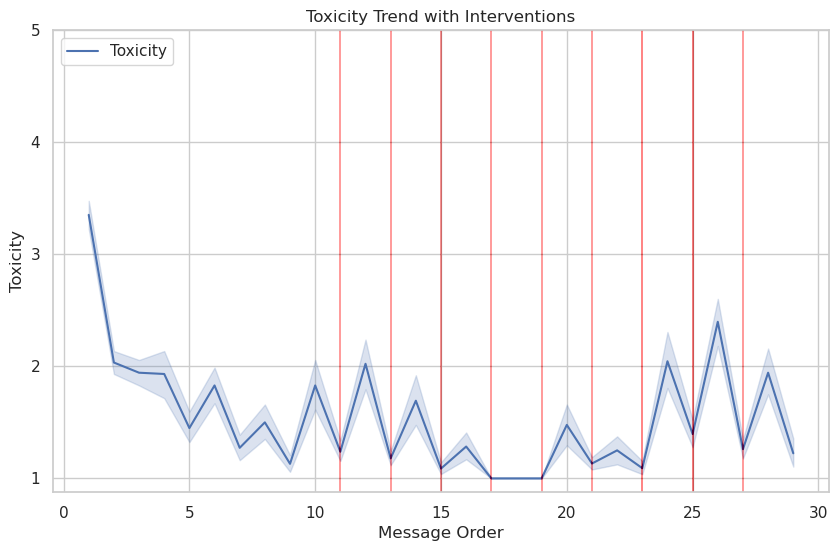

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter intervention data
intervention_df = full_df[full_df.conv_variant == "No Instructions"]

# Create the plot
plt.figure(figsize=(10, 6))

# Lineplot for toxicity over message order
sns.lineplot(data=intervention_df, x="message_order", y="toxicity", label="Toxicity")

# Add vertical dashed red lines where not_intervened is True
for msg_order in intervention_df.loc[intervention_df["not_intervened"], "message_order"]:
    plt.axvline(x=msg_order, color="red", linestyle="dashed", lw=0.02, alpha=0.2)

# Labels and title
plt.xlabel("Message Order")
plt.ylabel("Toxicity")
plt.title("Toxicity Trend with Interventions")
plt.yticks(TOXICITY_TICKS)

# Show plot
plt.show()


Repeat for each individual discussion

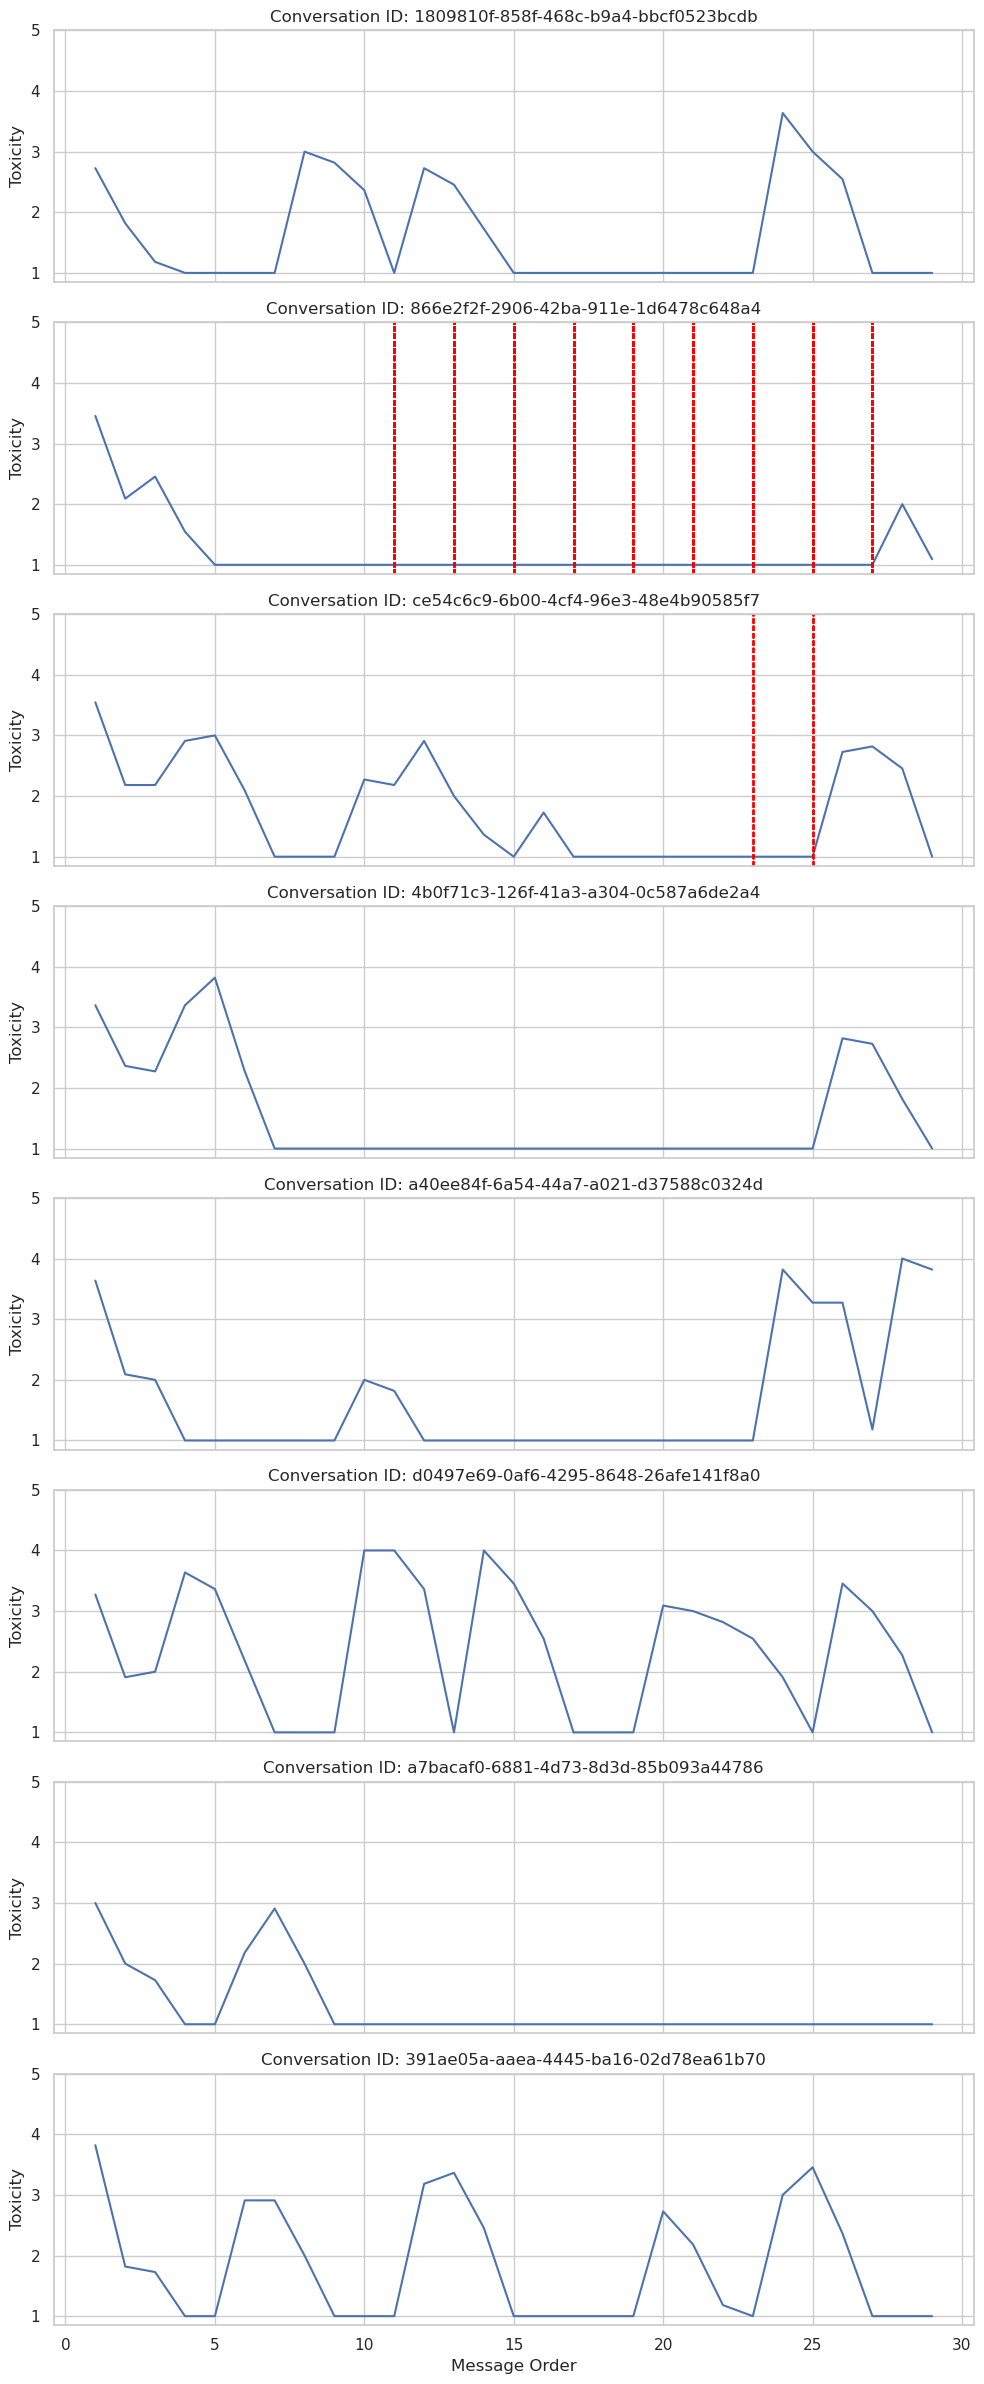

In [25]:
intervention_df = full_df[full_df.conv_variant == "No Instructions"]

# Create subplots (one for each conversation)
conv_ids = intervention_df.conv_id.unique()
fig, axes = plt.subplots(len(conv_ids), 1, figsize=(10, 3 * len(conv_ids)), sharex=True, sharey=True)

if len(conv_ids) == 1:
    axes = [axes]

for ax, conv_id in zip(axes, conv_ids):
    local_df = intervention_df[intervention_df.conv_id == conv_id]
    
    # Lineplot for toxicity trend
    sns.lineplot(data=local_df, x="message_order", y="toxicity", ax=ax, errorbar=None)
    
    # Add vertical dashed red lines for not_intervened points
    for msg_order in local_df.loc[local_df["not_intervened"], "message_order"]:
        ax.axvline(x=msg_order, color="red", linestyle="dashed", lw=1, alpha=0.5)
    
    ax.set_title(f"Conversation ID: {conv_id}")
    ax.set_ylabel("Toxicity")
    ax.set_yticks(TOXICITY_TICKS)


plt.xlabel("Message Order")
plt.tight_layout()
plt.show()


Non-interventions are an anomaly seen in mostly one discussion.